# A4-Q3: Convolutional Autoencoders

## Preliminaries

In [70]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [71]:
# In case you are fortunate enough to have access to a GPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset: MNIST

In [72]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))

In [73]:
ds = torch.utils.data.Subset(ds_full, range(1024))

In [74]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

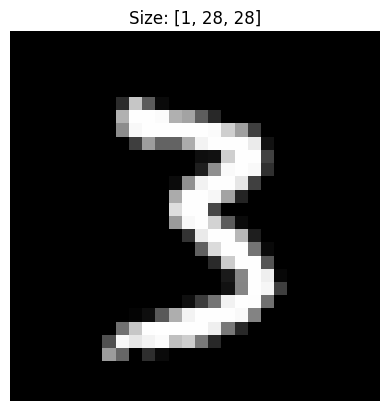

In [77]:
with torch.no_grad():
    x,t = ds.__getitem__(130)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

## Create some `DataLoader`s

In [78]:
# Batched, for training
batch_size_train = 8
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [79]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# A. Complete the `ConvAE` class

In [80]:
class ConvAE(nn.Module):
    '''
     net = ConvAE(img_size=28, embedding_dim=3)
     
     Create a convolutional autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images, [1, img_size, img_size]
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = ConvAE()
       y = net(x)
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=3):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        #===== YOUR CODE HERE =====
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_enc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, embedding_dim),
            nn.Tanh()
        )

        self.fc_dec = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (64, 4, 4))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        #===== YOUR CODE HERE =====
        x = self.encoder(x)
        h = self.fc_enc(x)
        return h
    
    
    def decode(self, x):
        #===== YOUR CODE HERE =====
        h = self.fc_dec(x)
        x = self.decoder(h)
        x = x[:, :, :self.img_size, :self.img_size]
        return x
  

    def forward(self, x):
        #===== YOUR CODE HERE =====
        h = self.encode(x)
        y = self.decode(h)
        return y


# B. Create and train the network

In [81]:
net = ConvAE(img_size=img_size, embedding_dim=3)

In [82]:
# Train it
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
epochs = 100

for epoch in range(epochs):
    net.train()
    running_loss = 0

    for x, _ in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
        x = x.to(device)

        y_pred = net(x)

        loss = criterion(y_pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dl)
    net.losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}]  Average Loss: {avg_loss:.6f}")

print("\nTraining complete!")

Epoch 1/100: 100%|██████████| 128/128 [00:00<00:00, 298.93it/s]


Epoch [1/100]  Average Loss: 0.094311


Epoch 2/100: 100%|██████████| 128/128 [00:00<00:00, 333.11it/s]


Epoch [2/100]  Average Loss: 0.066325


Epoch 3/100: 100%|██████████| 128/128 [00:00<00:00, 297.87it/s]


Epoch [3/100]  Average Loss: 0.066098


Epoch 4/100: 100%|██████████| 128/128 [00:00<00:00, 305.37it/s]


Epoch [4/100]  Average Loss: 0.066066


Epoch 5/100: 100%|██████████| 128/128 [00:00<00:00, 316.04it/s]


Epoch [5/100]  Average Loss: 0.066016


Epoch 6/100: 100%|██████████| 128/128 [00:00<00:00, 282.23it/s]


Epoch [6/100]  Average Loss: 0.065992


Epoch 7/100: 100%|██████████| 128/128 [00:00<00:00, 321.09it/s]


Epoch [7/100]  Average Loss: 0.066038


Epoch 8/100: 100%|██████████| 128/128 [00:00<00:00, 326.99it/s]


Epoch [8/100]  Average Loss: 0.065589


Epoch 9/100: 100%|██████████| 128/128 [00:00<00:00, 336.16it/s]


Epoch [9/100]  Average Loss: 0.061889


Epoch 10/100: 100%|██████████| 128/128 [00:00<00:00, 301.06it/s]


Epoch [10/100]  Average Loss: 0.058413


Epoch 11/100: 100%|██████████| 128/128 [00:00<00:00, 319.25it/s]


Epoch [11/100]  Average Loss: 0.053229


Epoch 12/100: 100%|██████████| 128/128 [00:00<00:00, 347.75it/s]


Epoch [12/100]  Average Loss: 0.050628


Epoch 13/100: 100%|██████████| 128/128 [00:00<00:00, 326.38it/s]


Epoch [13/100]  Average Loss: 0.047173


Epoch 14/100: 100%|██████████| 128/128 [00:00<00:00, 314.01it/s]


Epoch [14/100]  Average Loss: 0.044147


Epoch 15/100: 100%|██████████| 128/128 [00:00<00:00, 335.90it/s]


Epoch [15/100]  Average Loss: 0.042780


Epoch 16/100: 100%|██████████| 128/128 [00:00<00:00, 331.97it/s]


Epoch [16/100]  Average Loss: 0.041491


Epoch 17/100: 100%|██████████| 128/128 [00:00<00:00, 334.59it/s]


Epoch [17/100]  Average Loss: 0.040398


Epoch 18/100: 100%|██████████| 128/128 [00:00<00:00, 336.09it/s]


Epoch [18/100]  Average Loss: 0.039726


Epoch 19/100: 100%|██████████| 128/128 [00:00<00:00, 339.70it/s]


Epoch [19/100]  Average Loss: 0.038845


Epoch 20/100: 100%|██████████| 128/128 [00:00<00:00, 312.60it/s]


Epoch [20/100]  Average Loss: 0.038110


Epoch 21/100: 100%|██████████| 128/128 [00:00<00:00, 328.88it/s]


Epoch [21/100]  Average Loss: 0.037718


Epoch 22/100: 100%|██████████| 128/128 [00:00<00:00, 339.22it/s]


Epoch [22/100]  Average Loss: 0.037302


Epoch 23/100: 100%|██████████| 128/128 [00:00<00:00, 336.29it/s]


Epoch [23/100]  Average Loss: 0.036799


Epoch 24/100: 100%|██████████| 128/128 [00:00<00:00, 336.74it/s]


Epoch [24/100]  Average Loss: 0.036237


Epoch 25/100: 100%|██████████| 128/128 [00:00<00:00, 337.17it/s]


Epoch [25/100]  Average Loss: 0.036009


Epoch 26/100: 100%|██████████| 128/128 [00:00<00:00, 334.59it/s]


Epoch [26/100]  Average Loss: 0.035396


Epoch 27/100: 100%|██████████| 128/128 [00:00<00:00, 330.67it/s]


Epoch [27/100]  Average Loss: 0.035097


Epoch 28/100: 100%|██████████| 128/128 [00:00<00:00, 346.76it/s]


Epoch [28/100]  Average Loss: 0.034641


Epoch 29/100: 100%|██████████| 128/128 [00:00<00:00, 342.58it/s]


Epoch [29/100]  Average Loss: 0.034551


Epoch 30/100: 100%|██████████| 128/128 [00:00<00:00, 336.88it/s]


Epoch [30/100]  Average Loss: 0.034383


Epoch 31/100: 100%|██████████| 128/128 [00:00<00:00, 352.53it/s]


Epoch [31/100]  Average Loss: 0.033887


Epoch 32/100: 100%|██████████| 128/128 [00:00<00:00, 353.96it/s]


Epoch [32/100]  Average Loss: 0.033738


Epoch 33/100: 100%|██████████| 128/128 [00:00<00:00, 356.37it/s]


Epoch [33/100]  Average Loss: 0.033376


Epoch 34/100: 100%|██████████| 128/128 [00:00<00:00, 314.48it/s]


Epoch [34/100]  Average Loss: 0.033217


Epoch 35/100: 100%|██████████| 128/128 [00:00<00:00, 325.81it/s]


Epoch [35/100]  Average Loss: 0.033032


Epoch 36/100: 100%|██████████| 128/128 [00:00<00:00, 319.99it/s]


Epoch [36/100]  Average Loss: 0.032820


Epoch 37/100: 100%|██████████| 128/128 [00:00<00:00, 334.34it/s]


Epoch [37/100]  Average Loss: 0.032732


Epoch 38/100: 100%|██████████| 128/128 [00:00<00:00, 344.01it/s]


Epoch [38/100]  Average Loss: 0.032297


Epoch 39/100: 100%|██████████| 128/128 [00:00<00:00, 355.82it/s]


Epoch [39/100]  Average Loss: 0.032170


Epoch 40/100: 100%|██████████| 128/128 [00:00<00:00, 329.93it/s]


Epoch [40/100]  Average Loss: 0.032210


Epoch 41/100: 100%|██████████| 128/128 [00:00<00:00, 344.81it/s]


Epoch [41/100]  Average Loss: 0.031973


Epoch 42/100: 100%|██████████| 128/128 [00:00<00:00, 301.96it/s]


Epoch [42/100]  Average Loss: 0.031800


Epoch 43/100: 100%|██████████| 128/128 [00:00<00:00, 310.39it/s]


Epoch [43/100]  Average Loss: 0.031709


Epoch 44/100: 100%|██████████| 128/128 [00:00<00:00, 283.62it/s]


Epoch [44/100]  Average Loss: 0.031687


Epoch 45/100: 100%|██████████| 128/128 [00:00<00:00, 310.97it/s]


Epoch [45/100]  Average Loss: 0.031582


Epoch 46/100: 100%|██████████| 128/128 [00:00<00:00, 293.78it/s]


Epoch [46/100]  Average Loss: 0.031273


Epoch 47/100: 100%|██████████| 128/128 [00:00<00:00, 335.98it/s]


Epoch [47/100]  Average Loss: 0.031180


Epoch 48/100: 100%|██████████| 128/128 [00:00<00:00, 300.94it/s]


Epoch [48/100]  Average Loss: 0.031075


Epoch 49/100: 100%|██████████| 128/128 [00:00<00:00, 323.50it/s]


Epoch [49/100]  Average Loss: 0.030884


Epoch 50/100: 100%|██████████| 128/128 [00:00<00:00, 336.76it/s]


Epoch [50/100]  Average Loss: 0.030669


Epoch 51/100: 100%|██████████| 128/128 [00:00<00:00, 332.24it/s]


Epoch [51/100]  Average Loss: 0.030905


Epoch 52/100: 100%|██████████| 128/128 [00:00<00:00, 326.23it/s]


Epoch [52/100]  Average Loss: 0.030613


Epoch 53/100: 100%|██████████| 128/128 [00:00<00:00, 329.22it/s]


Epoch [53/100]  Average Loss: 0.030437


Epoch 54/100: 100%|██████████| 128/128 [00:00<00:00, 327.41it/s]


Epoch [54/100]  Average Loss: 0.030602


Epoch 55/100: 100%|██████████| 128/128 [00:00<00:00, 334.88it/s]


Epoch [55/100]  Average Loss: 0.030307


Epoch 56/100: 100%|██████████| 128/128 [00:00<00:00, 330.00it/s]


Epoch [56/100]  Average Loss: 0.030160


Epoch 57/100: 100%|██████████| 128/128 [00:00<00:00, 332.22it/s]


Epoch [57/100]  Average Loss: 0.030249


Epoch 58/100: 100%|██████████| 128/128 [00:00<00:00, 322.36it/s]


Epoch [58/100]  Average Loss: 0.030046


Epoch 59/100: 100%|██████████| 128/128 [00:00<00:00, 336.16it/s]


Epoch [59/100]  Average Loss: 0.029871


Epoch 60/100: 100%|██████████| 128/128 [00:00<00:00, 329.00it/s]


Epoch [60/100]  Average Loss: 0.029734


Epoch 61/100: 100%|██████████| 128/128 [00:00<00:00, 334.79it/s]


Epoch [61/100]  Average Loss: 0.029833


Epoch 62/100: 100%|██████████| 128/128 [00:00<00:00, 276.68it/s]


Epoch [62/100]  Average Loss: 0.029598


Epoch 63/100: 100%|██████████| 128/128 [00:00<00:00, 321.75it/s]


Epoch [63/100]  Average Loss: 0.029699


Epoch 64/100: 100%|██████████| 128/128 [00:00<00:00, 318.65it/s]


Epoch [64/100]  Average Loss: 0.029592


Epoch 65/100: 100%|██████████| 128/128 [00:00<00:00, 291.10it/s]


Epoch [65/100]  Average Loss: 0.029303


Epoch 66/100: 100%|██████████| 128/128 [00:00<00:00, 336.37it/s]


Epoch [66/100]  Average Loss: 0.029678


Epoch 67/100: 100%|██████████| 128/128 [00:00<00:00, 220.99it/s]


Epoch [67/100]  Average Loss: 0.029353


Epoch 68/100: 100%|██████████| 128/128 [00:00<00:00, 222.24it/s]


Epoch [68/100]  Average Loss: 0.029115


Epoch 69/100: 100%|██████████| 128/128 [00:00<00:00, 275.35it/s]


Epoch [69/100]  Average Loss: 0.029124


Epoch 70/100: 100%|██████████| 128/128 [00:00<00:00, 293.04it/s]


Epoch [70/100]  Average Loss: 0.028942


Epoch 71/100: 100%|██████████| 128/128 [00:00<00:00, 302.34it/s]


Epoch [71/100]  Average Loss: 0.028969


Epoch 72/100: 100%|██████████| 128/128 [00:00<00:00, 273.53it/s]


Epoch [72/100]  Average Loss: 0.028793


Epoch 73/100: 100%|██████████| 128/128 [00:00<00:00, 297.84it/s]


Epoch [73/100]  Average Loss: 0.028687


Epoch 74/100: 100%|██████████| 128/128 [00:00<00:00, 299.20it/s]


Epoch [74/100]  Average Loss: 0.029036


Epoch 75/100: 100%|██████████| 128/128 [00:00<00:00, 284.33it/s]


Epoch [75/100]  Average Loss: 0.028865


Epoch 76/100: 100%|██████████| 128/128 [00:00<00:00, 314.80it/s]


Epoch [76/100]  Average Loss: 0.028479


Epoch 77/100: 100%|██████████| 128/128 [00:00<00:00, 311.05it/s]


Epoch [77/100]  Average Loss: 0.028582


Epoch 78/100: 100%|██████████| 128/128 [00:00<00:00, 304.87it/s]


Epoch [78/100]  Average Loss: 0.028654


Epoch 79/100: 100%|██████████| 128/128 [00:00<00:00, 314.92it/s]


Epoch [79/100]  Average Loss: 0.028408


Epoch 80/100: 100%|██████████| 128/128 [00:00<00:00, 271.30it/s]


Epoch [80/100]  Average Loss: 0.028271


Epoch 81/100: 100%|██████████| 128/128 [00:00<00:00, 307.28it/s]


Epoch [81/100]  Average Loss: 0.028317


Epoch 82/100: 100%|██████████| 128/128 [00:00<00:00, 292.36it/s]


Epoch [82/100]  Average Loss: 0.028206


Epoch 83/100: 100%|██████████| 128/128 [00:00<00:00, 311.44it/s]


Epoch [83/100]  Average Loss: 0.028313


Epoch 84/100: 100%|██████████| 128/128 [00:00<00:00, 306.14it/s]


Epoch [84/100]  Average Loss: 0.028031


Epoch 85/100: 100%|██████████| 128/128 [00:00<00:00, 306.73it/s]


Epoch [85/100]  Average Loss: 0.028088


Epoch 86/100: 100%|██████████| 128/128 [00:00<00:00, 302.02it/s]


Epoch [86/100]  Average Loss: 0.028096


Epoch 87/100: 100%|██████████| 128/128 [00:00<00:00, 298.97it/s]


Epoch [87/100]  Average Loss: 0.027919


Epoch 88/100: 100%|██████████| 128/128 [00:00<00:00, 287.16it/s]


Epoch [88/100]  Average Loss: 0.027987


Epoch 89/100: 100%|██████████| 128/128 [00:00<00:00, 308.92it/s]


Epoch [89/100]  Average Loss: 0.027994


Epoch 90/100: 100%|██████████| 128/128 [00:00<00:00, 292.34it/s]


Epoch [90/100]  Average Loss: 0.027649


Epoch 91/100: 100%|██████████| 128/128 [00:00<00:00, 305.27it/s]


Epoch [91/100]  Average Loss: 0.027555


Epoch 92/100: 100%|██████████| 128/128 [00:00<00:00, 312.63it/s]


Epoch [92/100]  Average Loss: 0.027720


Epoch 93/100: 100%|██████████| 128/128 [00:00<00:00, 308.72it/s]


Epoch [93/100]  Average Loss: 0.027724


Epoch 94/100: 100%|██████████| 128/128 [00:00<00:00, 303.76it/s]


Epoch [94/100]  Average Loss: 0.027465


Epoch 95/100: 100%|██████████| 128/128 [00:00<00:00, 309.01it/s]


Epoch [95/100]  Average Loss: 0.027553


Epoch 96/100: 100%|██████████| 128/128 [00:00<00:00, 310.87it/s]


Epoch [96/100]  Average Loss: 0.027673


Epoch 97/100: 100%|██████████| 128/128 [00:00<00:00, 304.92it/s]


Epoch [97/100]  Average Loss: 0.027372


Epoch 98/100: 100%|██████████| 128/128 [00:00<00:00, 310.46it/s]


Epoch [98/100]  Average Loss: 0.027316


Epoch 99/100: 100%|██████████| 128/128 [00:00<00:00, 267.35it/s]


Epoch [99/100]  Average Loss: 0.027343


Epoch 100/100: 100%|██████████| 128/128 [00:00<00:00, 272.13it/s]

Epoch [100/100]  Average Loss: 0.027298

Training complete!


In [83]:
# Uncomment the following line if you want to save your network.
#torch.save(net.to('cpu'), 'my_ConvAE.pt')
# The corresponding code to reload the network is below.
#net = torch.load('my_ConvAE.pt')
# Remember to send it to the GPU, if you're using one.
net.to(device)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Tanh()
  )
  (fc_dec): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(64, 4, 4))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=Tr

# C. Plot the latent space

In [84]:
# Here are 10 colours you can use. But feel free to use others, too.
colour_options = ['k', 'tab:brown', 'r', 'orange', 'gold', 'lawngreen', 'forestgreen', 'blue', 'mediumpurple', 'gray']

In [ ]:
# Compute the latent-space representation for all the samples.


In [ ]:
# You can create three 2D planar projections.


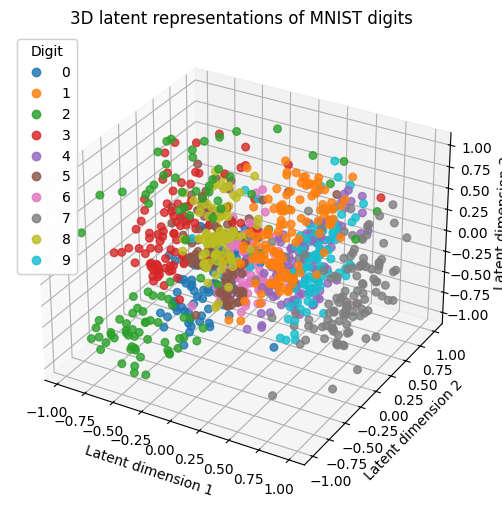

In [85]:
# Or you can plot a 3D scatter plot.
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

#===== YOUR CODE HERE =====

net.eval()
all_x, all_t = next(iter(train_all))
all_x = all_x.to(device)

with torch.no_grad():
    h = net.encode(all_x).cpu().numpy()  # shape [1024, 3]
labels = all_t.numpy()

sc = ax.scatter(h[:,0], h[:,1], h[:,2],
                c=labels, cmap='tab10', s=30, alpha=0.8)

ax.set_xlabel('Latent dimension 1')
ax.set_ylabel('Latent dimension 2')
ax.set_zlabel('Latent dimension 3')
ax.set_title('3D latent representations of MNIST digits')

legend = ax.legend(*sc.legend_elements(), title="Digit")
ax.add_artist(legend)

plt.show()


# D. Plot reconstructed digit images

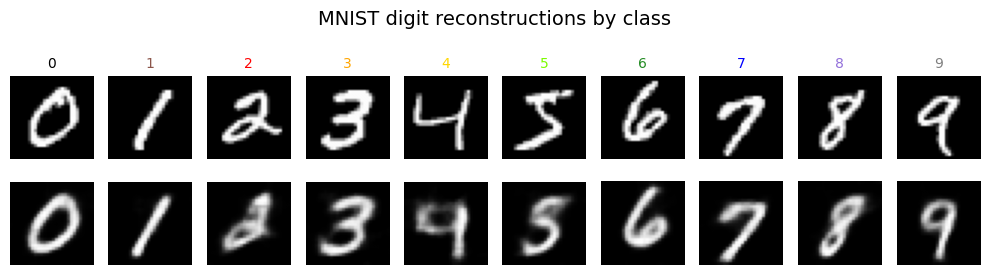

In [88]:
net.eval()

all_x, all_t = next(iter(train_all))
all_x = all_x.to(device)
all_t = all_t.numpy()

with torch.no_grad():
    y = net(all_x).cpu()

examples = []
for digit in range(10):
    idx = np.where(all_t == digit)[0][0]  # <-- fixed line
    examples.append((digit, all_x[idx], y[idx]))

plt.figure(figsize=(10, 3))

# Top row (inputs)
for i, (digit, orig, recon) in enumerate(examples):
    plt.subplot(2, 10, i + 1)
    plt.imshow(orig.squeeze().cpu(), cmap='gray')
    plt.title(str(digit), color=colour_options[digit], fontsize=10)
    plt.axis('off')
    if i == 0:
        plt.ylabel("Input", fontsize=12)

# Bottom row (reconstructions)
for i, (digit, orig, recon) in enumerate(examples):
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(recon.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Output", fontsize=12)

plt.suptitle("MNIST digit reconstructions by class", fontsize=14)
plt.tight_layout()
plt.show()


Digit Reconstructions

